In [0]:
import tensorflow as tf
import numpy as np
import os, shutil
from tensorflow.keras.layers import *
import glob
import random
from PIL import Image
import cv2
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import matplotlib as mpl

## **Clone Repository From Github**

In [2]:
! git clone "https://github.com/tusharsircar95/All-In-One-Image-Dehazing-Tensorflow/"

Cloning into 'All-In-One-Image-Dehazing-Tensorflow'...
remote: Enumerating objects: 28757, done.
remote: Counting objects: 100% (28757/28757), done.
remote: Compressing objects: 100% (28739/28739), done.
remote: Total 28757 (delta 18), reused 28752 (delta 16), pack-reused 0
Receiving objects: 100% (28757/28757), 944.40 MiB | 21.70 MiB/s, done.
Resolving deltas: 100% (18/18), done.
Checking out files: 100% (28743/28743), done.


# **Hyperparameters**

In [0]:
n_epochs = 10
batch_size = 8
learning_rate = 1e-4
weight_decay = 1e-4

# **Network Definition**

In [0]:
def haze_net(X):
  
  conv1 = Conv2D(3,1,1,padding="SAME",activation="relu",use_bias=True,kernel_initializer=tf.initializers.random_normal(),
                kernel_regularizer=tf.keras.regularizers.l2(weight_decay))(X)
  conv2 = Conv2D(3,3,1,padding="SAME",activation="relu",use_bias=True,kernel_initializer=tf.initializers.random_normal(),
                kernel_regularizer=tf.keras.regularizers.l2(weight_decay))(conv1)
  concat1 = tf.concat([conv1,conv2],axis=-1)
  
  conv3 = Conv2D(3,5,1,padding="SAME",activation="relu",use_bias=True,kernel_initializer=tf.initializers.random_normal(),
                kernel_regularizer=tf.keras.regularizers.l2(weight_decay))(concat1)
  concat2 = tf.concat([conv2,conv3],axis=-1)
  
  conv4 = Conv2D(3,7,1,padding="SAME",activation="relu",use_bias=True,kernel_initializer=tf.initializers.random_normal(),
                kernel_regularizer=tf.keras.regularizers.l2(weight_decay))(concat2)
  concat3 = tf.concat([conv1,conv2,conv3,conv4],axis=-1)
  
  conv5 = Conv2D(3,3,1,padding="SAME",activation="relu",use_bias=True,kernel_initializer=tf.initializers.random_normal(),
                kernel_regularizer=tf.keras.regularizers.l2(weight_decay))(concat3)
  K = conv5
  
  output = ReLU(max_value=1.0)(tf.math.multiply(K,X) - K + 1.0)
  #output = output / 255.0
  
  return output




# **Data Loading & Pre-processing**

In [0]:
def setup_data_paths(orig_images_path,hazy_images_path):
  
  orig_image_paths = glob.glob(orig_images_path + "/*.jpg")
  n = len(orig_image_paths) 
  random.shuffle(orig_image_paths)
  
  train_keys = orig_image_paths[:int(0.90*n)]
  val_keys = orig_image_paths[int(0.90*n):]
  
  
  split_dict = {}
  for key in train_keys:
    split_dict[key] = 'train'
  for key in val_keys:
    split_dict[key] = 'val'
  
  train_data = []
  val_data = []
  
  hazy_image_paths = glob.glob(hazy_images_path + "/*.jpg")
  for path in hazy_image_paths:
    label = path.split('/')[-1]
    orig_path = orig_images_path + "/" + label.split('_')[0] + '_' + label.split('_')[1] + ".jpg"
    if(split_dict[orig_path] == 'train'):
      train_data.append([path,orig_path])
    else: val_data.append([path,orig_path])
  
  return train_data, val_data
  

In [0]:
def load_image(X):
  X = tf.io.read_file(X)
  X = tf.image.decode_jpeg(X,channels=3)
  X = tf.image.resize(X,(480,640))
  X = X / 255.0
  return X

def showImage(x):
  x = np.asarray(x*255,dtype=np.int32)
  plt.figure()
  plt.imshow(x)
  plt.show()

In [0]:
def create_datasets(train_data,val_data,batch_size):
  
  train_ds_hazy = tf.data.Dataset.from_tensor_slices([data[0] for data in train_data]).map(lambda x: load_image(x))
  train_ds_orig = tf.data.Dataset.from_tensor_slices([data[1] for data in train_data]).map(lambda x: load_image(x))
  train_ds = tf.data.Dataset.zip((train_ds_hazy,train_ds_orig)).shuffle(100).repeat().batch(batch_size)

  val_ds_hazy = tf.data.Dataset.from_tensor_slices([data[0] for data in val_data]).map(lambda x: load_image(x))
  val_ds_orig = tf.data.Dataset.from_tensor_slices([data[1] for data in val_data]).map(lambda x: load_image(x))
  val_ds = tf.data.Dataset.zip((val_ds_hazy,val_ds_orig)).shuffle(100).repeat().batch(batch_size)

  iterator = tf.data.Iterator.from_structure(train_ds.output_types,train_ds.output_shapes)
  
  train_init_op = iterator.make_initializer(train_ds)
  val_init_op = iterator.make_initializer(val_ds)
  
  return train_init_op, val_init_op, iterator


# **Training**

In [0]:
tf.reset_default_graph()
train_data, val_data = setup_data_paths(orig_images_path="./All-In-One-Image-Dehazing-Tensorflow/data/orig_images",
                  hazy_images_path="./All-In-One-Image-Dehazing-Tensorflow/data/hazy_images");
train_init_op, val_init_op, iterator = create_datasets(train_data,val_data,batch_size)
next_element = iterator.get_next()

X = tf.placeholder(shape=(None,480,640,3),dtype=tf.float32)
Y = tf.placeholder(shape=(None,480,640,3),dtype=tf.float32)
dehazed_X = haze_net(X)

loss = tf.reduce_mean(tf.square(dehazed_X-Y))
optimizer = tf.train.AdamOptimizer(learning_rate)
trainable_variables = tf.trainable_variables()
gradients_and_vars = optimizer.compute_gradients(loss,trainable_variables)
clipped_gradients = [(tf.clip_by_norm(gradient,0.1),var) for gradient,var in gradients_and_vars]
optimizer = optimizer.apply_gradients(gradients_and_vars)


In [0]:

saver = tf.train.Saver()
load_path = None

with tf.device('/gpu:0'):
  with tf.Session() as sess:

    sess.run(tf.global_variables_initializer())
    for epoch in range(n_epochs):
      
      sess.run(train_init_op)
      batches = len(train_data) // batch_size
      epoch_loss = 0.0
      for batch in range(batches):

        batch_data = sess.run(next_element)
        #print(batch_data[0].shape,batch_data[1].shape)
        #print(np.max(batch_data[0]),np.max(batch_data[1]))
        batch_loss, _ = sess.run([loss,optimizer],feed_dict={X:batch_data[0],
                                                            Y:batch_data[1]})
        epoch_loss += batch_loss / float(batches)
        if batch % 1000 == 0:
          print("Training loss at batch %d: %f\n"%(batch,batch_loss))
            
      train_loss = epoch_loss

      sess.run(val_init_op)
      batches= len(val_data) // batch_size
      epoch_loss = 0.0
      for batch in range(batches):
        batch_data = sess.run(next_element)
        batch_loss = sess.run(loss,feed_dict={X:batch_data[0],
                                             Y:batch_data[1]})
        epoch_loss += batch_loss / float(batches)
        if batch % 100 == 0:
          print("Validation loss at batch %d: %f\n"%(batch,batch_loss))
          for j in range(batch_size//2):
            x = batch_data[0][j].reshape((1,)+batch_data[0][j].shape)
            y = batch_data[1][j].reshape((1,)+batch_data[1][j].shape)
            dehazed_x = sess.run(dehazed_X,feed_dict={X:x,Y:y})
            print("Image Number: %d\n"%(j))
            showImage(x[0])
            showImage(y[0])
            showImage(dehazed_x[0])
      val_loss = epoch_loss

      saver.save(sess,'./models/model_checkpoint_' + str(epoch) + '.ckpt')
      
      print("Epoch %d\nTraining loss: %f\nValidation loss: %f\n\n"%(epoch,train_loss,val_loss))
    

    

In [0]:
next_element = iterator.get_next()

with tf.Session() as sess:
  sess.run(val_init_op)
  
  for i in range(10):
    batch_data = sess.run(next_element)
    for j in range(4):
      x = batch_data[0][j].reshape((1,)+batch_data[0][j].shape)
      showImage(x)

In [0]:
os.mkdir('./models')

## **Evaluation**

In [11]:
tf.reset_default_graph()
train_data, val_data = setup_data_paths(orig_images_path="./All-In-One-Image-Dehazing-Tensorflow/data/orig_images",
                  hazy_images_path="./All-In-One-Image-Dehazing-Tensorflow/data/hazy_images");
train_init_op, val_init_op, iterator = create_datasets(train_data,val_data,batch_size)
next_element = iterator.get_next()

X = tf.placeholder(shape=(None,480,640,3),dtype=tf.float32)
Y = tf.placeholder(shape=(None,480,640,3),dtype=tf.float32)
dehazed_X = haze_net(X)

loss = tf.reduce_mean(tf.square(dehazed_X-Y))
optimizer = tf.train.AdamOptimizer(learning_rate)
trainable_variables = tf.trainable_variables()
gradients_and_vars = optimizer.compute_gradients(loss,trainable_variables)
clipped_gradients = [(tf.clip_by_norm(gradient,0.1),var) for gradient,var in gradients_and_vars]
optimizer = optimizer.apply_gradients(gradients_and_vars)


W0813 13:42:14.863815 140387773286272 deprecation.py:323] From <ipython-input-10-c4a4d44c0124>:11: DatasetV1.output_types (from tensorflow.python.data.ops.dataset_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.compat.v1.data.get_output_types(dataset)`.
W0813 13:42:14.865221 140387773286272 deprecation.py:323] From <ipython-input-10-c4a4d44c0124>:11: DatasetV1.output_shapes (from tensorflow.python.data.ops.dataset_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.compat.v1.data.get_output_shapes(dataset)`.
W0813 13:42:14.873634 140387773286272 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/iterator_ops.py:348: Iterator.output_types (from tensorflow.python.data.ops.iterator_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.compat.v1.data.get_output_types(iterator)`.
W0813 13:42:14.874395 140387773286272 depre

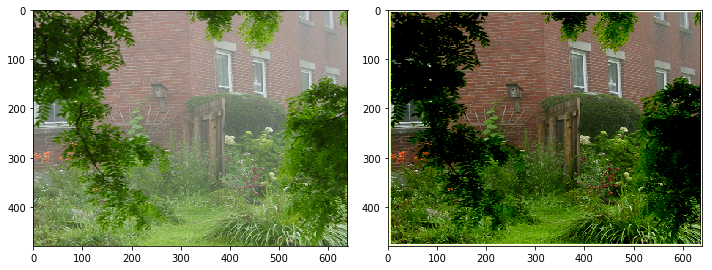

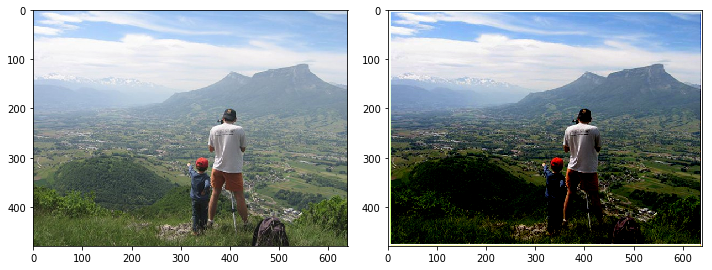

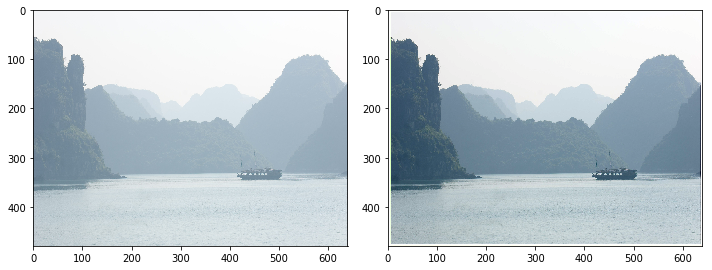

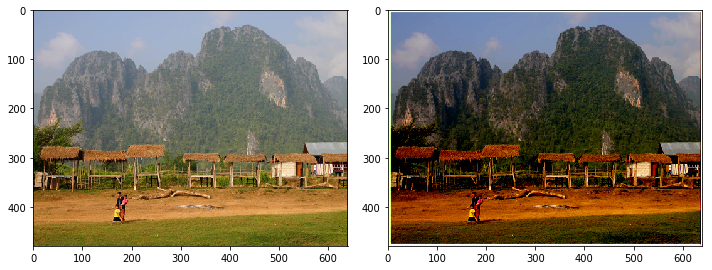

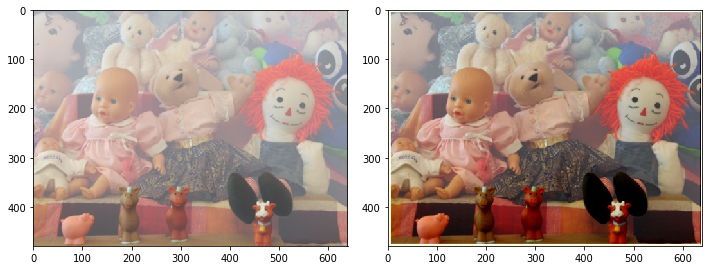

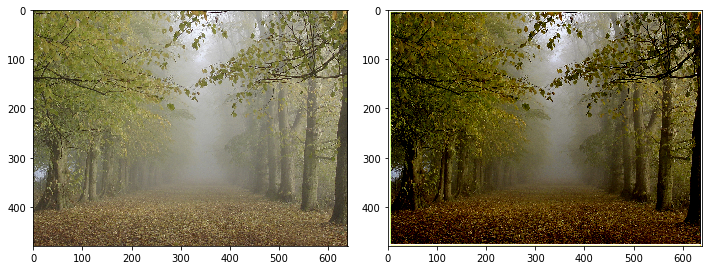

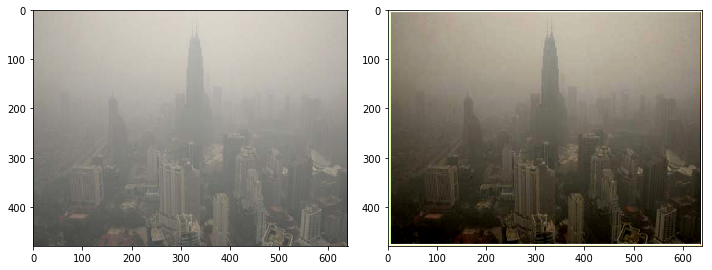

In [21]:
saver = tf.train.Saver()


test_input_folder = "./All-In-One-Image-Dehazing-Tensorflow/test_images"
test_output_folder = "./All-In-One-Image-Dehazing-Tensorflow/dehazed_test_images"
if not os.path.exists(test_output_folder):
  os.mkdir(test_output_folder)
  
file_types = ['jpeg','jpg']

with tf.Session() as sess:
  saver.restore(sess,'./All-In-One-Image-Dehazing-Tensorflow/models/model_checkpoint_7.ckpt')
  
  test_image_paths = []
  for file_type in file_types:
    test_image_paths.extend(glob.glob(test_input_folder+"/*."+file_type))
  
  
  for path in test_image_paths:
    image_label = path.split(test_input_folder)[-1][1:]
    image = Image.open(path)
    image = image.resize((640, 480))
    image = np.asarray(image) / 255.0
    image = image.reshape((1,) + image.shape)
    dehazed_image = sess.run(dehazed_X,feed_dict={X:image,Y:image})
    
    
    fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(10,10))
    axes[0].imshow(image[0])
    axes[1].imshow(dehazed_image[0])
    fig.tight_layout()
    
    dehazed_image = np.asarray(dehazed_image[0] * 255,dtype=np.uint8)
    mpl.image.imsave(test_output_folder + "/" + 'dehazed_' + image_label, dehazed_image)
    
  

In [0]:
os.mkdir("./results")